# Transonic flow through cylinder with 2D Euler equations

This code is modified from the code https://github.com/alexpapados/Physics-Informed-Deep-Learning-Solid-and-Fluid-Mechanics

The paper about this work can ref https://www.researchgate.net/publication/359480166_Discontinuity_Computing_with_Physics-Informed_Neural_Network

In [1]:
import torch
import torch.nn as nn
import numpy as np
import time
import scipy.io
import matplotlib.pyplot as plt
from numpy import arange, meshgrid
from smt.sampling_methods import LHS
# Seeds
torch.manual_seed(123)
np.random.seed(123)
def train(epoch):
    model.train()
    def closure():
        optimizer.zero_grad()                                                     
        loss_pde = model.loss_pde(x_int_train)                                   
        loss_ic = model.loss_ic(x_ic_train, rho_ic_train,u_ic_train,v_ic_train,p_ic_train)   
        loss_bdL = model.loss_bc(x_bcL_train, rho_bcL_train,u_bcL_train,v_bcL_train,p_bcL_train)   
       # loss_bdR = model.loss_bc1(x_bcR_train,rho_bcR_train,u_bcR_train,v_bcR_train,p_bcR_train)   
        loss_bdI = model.bd_B(x_bcI_train, sin_bcI_train,cos_bcI_train)  

        loss_ib = loss_ic  +  loss_bdI +loss_bdL
        loss = loss_pde + 10*loss_ib

        print(f'epoch {epoch} loss_pde:{loss_pde:.8f}, loss_ib:{loss_ib:.8f}')
        loss.backward()
        return loss

    # Optimize loss function
    loss = optimizer.step(closure)
    loss_value = loss.item() if not isinstance(loss, float) else loss
    # Print total loss
    print(f'epoch {epoch}: loss {loss_value:.6f}')
    
# Calculate gradients using torch.autograd.grad
def gradients(outputs, inputs):
    return torch.autograd.grad(outputs, inputs,grad_outputs=torch.ones_like(outputs), create_graph=True)

# Convert torch tensor into np.array
def to_numpy(input):
    if isinstance(input, torch.Tensor):
        return input.detach().cpu().numpy()
    elif isinstance(input, np.ndarray):
        return input
    else:
        raise TypeError('Unknown type of input, expected torch.Tensor or ' \
                        'np.ndarray, but got {}'.format(type(input)))
def IC(x):
    N =x.shape[0]
    rho_init = np.zeros((x.shape[0]))                                              # rho - initial condition
    u_init = np.zeros((x.shape[0]))                                                # u - initial condition
    v_init = np.zeros((x.shape[0]))                                                # u - initial condition
    p_init = np.zeros((x.shape[0]))                                                # p - initial condition
    
    gamma = 1.4
    rho1 = 2.112
    p1 =  3.011
    v1 = 0.0
    u1 = np.sqrt(1.4*p1/rho1)*0.728
    
    for i in range(N):
        rho_init[i] = rho1
        u_init[i] =   u1
        v_init[i] =  v1
        p_init[i] =  p1
    return rho_init, u_init, v_init,p_init

def BC_L(x):
    N =x.shape[0]
    rho_init = np.zeros((x.shape[0]))                                              # rho - initial condition
    u_init = np.zeros((x.shape[0]))                                                # u - initial condition
    v_init = np.zeros((x.shape[0]))                                                # u - initial condition
    p_init = np.zeros((x.shape[0]))                                                # p - initial condition
    
    gamma = 1.4
    #u1 = ms*npsqrt(gamma)
    # rho, p - initial condition
    rho1 = 2.112
    p1 =  3.011
    v1 = 0.0
    u1 = np.sqrt(1.4*p1/rho1)*0.728
    for i in range(N):
        rho_init[i] = rho1
        u_init[i] =  u1
        v_init[i] =  v1
        p_init[i] =  p1
    return rho_init, u_init, v_init,p_init
def BC_R(x):
    N =x.shape[0]
    rho_init = np.zeros((x.shape[0]))                                              # rho - initial condition
    u_init = np.zeros((x.shape[0]))                                                # u - initial condition
    v_init = np.zeros((x.shape[0]))                                                # u - initial condition
    p_init = np.zeros((x.shape[0]))                                                # p - initial condition
    
    gamma = 1.4
    ms = 2.0
    rho1 = 1.0
    p1 = 1.0
    v1 = 0.0
    u1 = 0
    # rho, p - initial condition
    for i in range(N):
        rho_init[i] = rho1
        u_init[i] = u1
        v_init[i] = v1
        p_init[i] = p1

    return rho_init, u_init, v_init,p_init

class DNN(nn.Module):

    def __init__(self):
        super(DNN, self).__init__()
        self.net = nn.Sequential()                                                  # Define neural network
        self.net.add_module('Linear_layer_1', nn.Linear(3, 90))                     # First linear layer
        self.net.add_module('Tanh_layer_1', nn.Tanh())                              # First activation Layer

        for num in range(2, 6):                                                     # Number of layers (2 through 7)
            self.net.add_module('Linear_layer_%d' % (num), nn.Linear(90, 90))       # Linear layer
            self.net.add_module('Tanh_layer_%d' % (num), nn.Tanh())                 # Activation Layer
        self.net.add_module('Linear_layer_final', nn.Linear(90, 4))                 # Output Layer

    # Forward Feed
    def forward(self, x):
        return self.net(x)

    def bd_B(self,x,sin,cos):
        yb = self.net(x)
        rhob,pb,ub,vb = yb[:, 0:1], yb[:, 1:2], yb[:, 2:3],yb[:,3:]
        drhob_g = gradients(rhob, x)[0]                                      # Gradient [u_t, u_x]
        rhob_x, rhob_y = drhob_g[:, 1:2], drhob_g[:, 2:3]                            # Partial derivatives u_t, u_x
        dub_g = gradients(ub, x)[0]                                      # Gradient [u_t, u_x]
        ub_x, ub_y = dub_g[:, 1:2], dub_g[:, 2:3]                            # Partial derivatives u_t, u_x
        dvb_g = gradients(vb, x)[0]                                      # Gradient [u_t, u_x]
        vb_x, vb_y = dvb_g[:, 1:2], dvb_g[:, 2:3]                            # Partial derivatives u_t, u_x
        dpb_g = gradients(pb, x)[0]                                      # Gradient [p_t, p_x]
        pb_x, pb_y = dpb_g[:, 1:2], dpb_g[:, 2:3]                            # Partial derivatives p_t, p_x
        
        deltau = ub_x + vb_y
        lam = 0.1*(abs(deltau) - deltau) + 1
        #lam = (deltau) - deltau) + 1
        
        fb = (((ub*cos + vb*sin)/lam)**2).mean() +\
            (((pb_x*cos + pb_y*sin)/lam)**2).mean() +\
            (((rhob_x*cos + rhob_y*sin)/lam)**2).mean()
        return fb
    def bd_OY(self,x):
        y = self.net(x)
        rho,p,u,v = y[:, 0:1], y[:, 1:2], y[:, 2:3],y[:,3:]
        
        drho_g = gradients(rho, x)[0]                                  # Gradient [rho_t, rho_x]
        rho_x,rho_y = drho_g[:, :1], drho_g[:, 1:2]                    # Partial derivatives rho_t, rho_x
        du_g = gradients(u, x)[0]                                      # Gradient [u_t, u_x]
        u_x, u_y = du_g[:, :1], du_g[:, 1:2]                            # Partial derivatives u_t, u_x
        dv_g = gradients(v, x)[0]                                      # Gradient [u_t, u_x]
        v_x, v_y = dv_g[:, :1], dv_g[:, 1:2]                            # Partial derivatives u_t, u_x
        dp_g = gradients(p, x)[0]                                      # Gradient [p_t, p_x]
        p_x, p_y = dp_g[:, :1], dp_g[:, 1:2]                            # Partial derivatives p_t, p_x
        
        deltau = u_x + v_y
        lam = 0.1*(abs(deltau) - deltau) + 1
        
        f = ((( u_y)/lam)**2).mean() +\
            ((( v_y)/lam)**2).mean() +\
            ((( p_y)/lam)**2).mean() +\
            ((( rho_y)/lam)**2).mean()
        return f
    
    def bd_OX(self,x):
        y = self.net(x)
        rho,p,u,v = y[:, 0:1], y[:, 1:2], y[:, 2:3],y[:,3:]
        
        drho_g = gradients(rho, x)[0]                                  # Gradient [rho_t, rho_x]
        rho_x,rho_y = drho_g[:, :1], drho_g[:, 1:2]                    # Partial derivatives rho_t, rho_x
        du_g = gradients(u, x)[0]                                      # Gradient [u_t, u_x]
        u_x, u_y = du_g[:, :1], du_g[:, 1:2]                            # Partial derivatives u_t, u_x
        dv_g = gradients(v, x)[0]                                      # Gradient [u_t, u_x]
        v_x, v_y = dv_g[:, :1], dv_g[:, 1:2]                            # Partial derivatives u_t, u_x
        dp_g = gradients(p, x)[0]                                      # Gradient [p_t, p_x]
        p_x, p_y = dp_g[:, :1], dp_g[:, 1:2]                            # Partial derivatives p_t, p_x
        
        deltau = u_x + v_y
        lam = 0.1*(abs(deltau) - deltau) + 1
        
        f = ((( u_x)/lam)**2).mean() +\
            ((( v_x)/lam)**2).mean() +\
            ((( p_x)/lam)**2).mean() +\
            ((( rho_x)/lam)**2).mean()
        return f
     
    # Loss function for PDE
    def loss_pde(self, x):
        
        y = self.net(x)
        gamma = 1.4                                                   
        epsilon = 1e-5
        rho,p,u,v = y[:, 0:1], y[:, 1:2], y[:, 2:3],y[:,3:]
        
        rhoE = p/(gamma - 1) +0.5*rho*(u**2+v**2)
        
        f1 = rho*u
        f2 = rho*u*u+p
        f3 = rho*u*v
        f4 = (rhoE+p)*u
        
        g1 = rho*v
        g2 = rho*v*u
        g3 = rho*v*v + p
        g4 = (rhoE+p)*v
        
        drho_g = gradients(rho,x)[0]
        U1_t = drho_g[:, :1]
        dU2_g = gradients(f1,x)[0]
        U2_t = dU2_g[:, :1]
        dU3_g = gradients(g1,x)[0]
        U3_t = dU3_g[:, :1]
        dU4_g = gradients(rhoE,x)[0]
        U4_t = dU4_g[:, :1]
        
        df1_g = gradients(f1, x)[0]                                  
        f1_x = df1_g[:, 1:2]
        df2_g = gradients(f2, x)[0]                                  
        f2_x = df2_g[:, 1:2]
        df3_g = gradients(f3, x)[0]                                  
        f3_x = df3_g[:, 1:2]
        df4_g = gradients(f4, x)[0]                                  
        f4_x = df4_g[:, 1:2]
        
        dg1_g = gradients(g1, x)[0]                                  
        g1_y = dg1_g[:, 2:3]
        dg2_g = gradients(g2, x)[0]                                  
        g2_y = dg2_g[:, 2:3]
        dg3_g = gradients(g3, x)[0]                                  
        g3_y = dg3_g[:, 2:3]
        dg4_g = gradients(g4, x)[0]                                  
        g4_y = dg4_g[:, 2:3]
        
        
        du_g = gradients(u, x)[0]                                
        u_x = du_g[:, 1:2]         
        dv_g = gradients(v, x)[0]                    
        v_y = dv_g[:, 2:3]         
        
        deltau = u_x + v_y
        nab = abs(deltau) - deltau
        
        lam = 0.1*nab + 1
        
        f = (((U1_t + f1_x+g1_y )/lam)**2).mean() +\
            (((U2_t + f2_x+g2_y )/lam)**2).mean() +\
            (((U3_t + f3_x+g3_y )/lam)**2).mean() +\
            (((U4_t + f4_x+g4_y )/lam)**2).mean()

        return f

    # Loss function for initial condition
    def loss_ic(self, x_ic, rho_ic, u_ic, v_ic,p_ic):
        U_ic = self.net(x_ic)                                                      # Initial condition
        rho_ic_nn, p_ic_nn,u_ic_nn,v_ic_nn = U_ic[:, 0], U_ic[:, 1], U_ic[:, 2],U_ic[:,3]            # rho, u, p - initial condition

        # Loss function for the initial condition
        loss_ics = ((u_ic_nn - u_ic) ** 2).mean() + \
               ((rho_ic_nn- rho_ic) ** 2).mean()  + \
               ((p_ic_nn - p_ic) ** 2).mean() +\
               ((v_ic_nn - v_ic) ** 2).mean()

        return loss_ics

    def loss_bc(self, x_ic, rho_ic, u_ic, v_ic,p_ic):
        U_ic = self.net(x_ic)                                                      # Initial condition
        rho_ic_nn, p_ic_nn,u_ic_nn,v_ic_nn = U_ic[:, 0], U_ic[:, 1], U_ic[:, 2],U_ic[:,3]            # rho, u, p - initial condition

        # Loss function for the initial condition
        loss_ics = ((u_ic_nn - u_ic) ** 2).mean() + \
               ((rho_ic_nn- rho_ic) ** 2).mean()  + \
               ((p_ic_nn - p_ic) ** 2).mean() +\
               ((v_ic_nn - v_ic) ** 2).mean()

        return loss_ics
    def loss_bc1(self, x_ic, rho_ic, u_ic, v_ic,p_ic):
        U_ic = self.net(x_ic)                                                      # Initial condition
        rho_ic_nn, p_ic_nn,u_ic_nn,v_ic_nn = U_ic[:, 0], U_ic[:, 1], U_ic[:, 2],U_ic[:,3]            # rho, u, p - initial condition

        # Loss function for the initial condition
        loss_ics = ((rho_ic_nn- rho_ic) ** 2).mean()  + \
               ((p_ic_nn - p_ic) ** 2).mean() 

        return loss_ics

def BD_circle(t,xc,yc,r,n):
    x = np.zeros((n,3)) 
    sin = np.zeros((n,1)) 
    cos = np.zeros((n,1)) 

    for i in range(n):
        the = 2*np.random.rand()*np.pi
        xd = np.cos(the + np.pi/2)
        yd = np.sin(the + np.pi/2)
        x[i,0] = np.random.rand()*t
        x[i,1] = xc  + xd*r
        x[i,2] = yc  + yd*r
        cos[i,0] = xd 
        sin[i,0] = yd
    return x, sin,cos


device = torch.device('cuda')                                          # Run on CPU
lr = 0.001                                                           # Learning rate
num_ib = 15000                                                # Random sampled points from IC0
num_int = 100000                                                # Random sampled points in interior
Tend = 0.4
Lx = 1.5
Ly = 2.0
rx = 1.0
ry = 1.0
rd = 0.25

xlimits = np.array([[0.,Tend],[0.0, Lx], [0,Ly]])  #interal
sampling = LHS(xlimits=xlimits)
x_int_train = sampling(num_int)
A = []
for i in range(num_int):
    x = x_int_train[i,1]
    y = x_int_train[i,2]
    if ((x - rx)**2 +(y-ry)**2< rd**2):
        A.append(i)
x_int_train = np.delete(x_int_train,A,axis=0)

xlimits = np.array([[0.,0.0],[0.0,Lx], [0.0,Ly]])  #interal
sampling = LHS(xlimits=xlimits)
x_ic_train = sampling(num_ib)
A = []
for i in range(num_ib):
    x = x_ic_train[i,1]
    y = x_ic_train[i,2]
    if ((x - rx)**2 +(y-ry)**2< rd**2):
        A.append(i)
x_ic_train = np.delete(x_ic_train,A,axis=0)


xlimits = np.array([[0.0,Tend],[0.0, 0.0], [0.0,Ly]])
sampling = LHS(xlimits=xlimits)
x_bcL_train =  sampling(num_ib)

xlimits = np.array([[0.0,Tend], [Lx, Lx], [0.0,Ly]])
sampling = LHS(xlimits=xlimits)
x_bcR_train =  sampling(num_ib)


xlimits = np.array([[0.0,Tend],[0.0, Lx], [Ly,Ly]])
sampling = LHS(xlimits=xlimits)
x_bcU_train =  sampling(num_ib)

xlimits = np.array([[0.0,Tend], [0.0, Lx], [0.0,0.0]])
sampling = LHS(xlimits=xlimits)
x_bcD_train =  sampling(num_ib)                                           # Vectorized whole domain



x_bcI_train,sin_bcI_train,cos_bcI_train = BD_circle(Tend,rx,ry,rd,num_ib)

rho_bcL_train, u_bcL_train,v_bcL_train, p_bcL_train = BC_L(x_bcL_train)  
rho_bcR_train, u_bcR_train,v_bcR_train, p_bcR_train = BC_L(x_bcR_train)  
rho_ic_train, u_ic_train,v_ic_train, p_ic_train = IC(x_ic_train)  


x_int_train = torch.tensor(x_int_train, requires_grad=True, dtype=torch.float32).to(device)

rho_bcL_train = torch.tensor(rho_bcL_train, dtype=torch.float32).to(device)
u_bcL_train = torch.tensor(u_bcL_train, dtype=torch.float32).to(device)
v_bcL_train = torch.tensor(v_bcL_train, dtype=torch.float32).to(device)
p_bcL_train = torch.tensor(p_bcL_train, dtype=torch.float32).to(device)

rho_bcR_train = torch.tensor(rho_bcR_train, dtype=torch.float32).to(device)
u_bcR_train = torch.tensor(u_bcR_train, dtype=torch.float32).to(device)
v_bcR_train = torch.tensor(v_bcR_train, dtype=torch.float32).to(device)
p_bcR_train = torch.tensor(p_bcR_train, dtype=torch.float32).to(device)

x_bcD_train = torch.tensor(x_bcD_train,requires_grad=True, dtype=torch.float32).to(device)
x_bcU_train = torch.tensor(x_bcU_train, requires_grad=True, dtype=torch.float32).to(device)
x_bcR_train = torch.tensor(x_bcR_train, requires_grad=True, dtype=torch.float32).to(device)
x_bcL_train = torch.tensor(x_bcL_train, dtype=torch.float32).to(device)
x_bcI_train = torch.tensor(x_bcI_train, requires_grad=True, dtype=torch.float32).to(device)
sin_bcI_train = torch.tensor(sin_bcI_train, dtype=torch.float32).to(device)
cos_bcI_train = torch.tensor(cos_bcI_train, dtype=torch.float32).to(device)

rho_ic_train = torch.tensor(rho_ic_train, dtype=torch.float32).to(device)
u_ic_train = torch.tensor(u_ic_train, dtype=torch.float32).to(device)
v_ic_train = torch.tensor(v_ic_train, dtype=torch.float32).to(device)
p_ic_train = torch.tensor(p_ic_train, dtype=torch.float32).to(device)
x_ic_train = torch.tensor(x_ic_train, dtype=torch.float32).to(device)


model = DNN().to(device)

print('Start training...')

Start training...


In [ ]:
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [3]:
epochs = 1
tic = time.time()
for epoch in range(1, epochs+1):
    train(epoch)
toc = time.time()
print(f'Total training time: {toc - tic}')


RuntimeError: CUDA out of memory. Tried to allocate 66.00 MiB (GPU 0; 10.91 GiB total capacity; 6.10 GiB already allocated; 62.94 MiB free; 6.29 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [17]:
lr = 0.0001
optimizer = torch.optim.LBFGS(model.parameters(),lr=1,max_iter=20)

In [ ]:
epochs = 10
tic = time.time()
for epoch in range(1, epochs+1):
    train(epoch)
toc = time.time()
print(f'Total training time: {toc - tic}')


In [82]:
device1 = torch.device("cpu")

In [10]:
Nd = 600
T = 1.0
t = np.linspace(T, T, 1)                                   # Partitioned spatial axis
x = np.linspace(0.0,Lx,Nd)                                   # Partitioned spatial axis
y = np.linspace(0.0,Ly,Nd)                                   # Partitioned spatial axis
t_grid,x_grid,y_grid = np.meshgrid(t,x,y)                                    # (t,x) in [0,0.2]x[a,b]
T = t_grid.flatten()[:, None]                                         # Vectorized x_grid
X = x_grid.flatten()[:, None]                                         # Vectorized x_grid
Y = y_grid.flatten()[:, None]                                         # Vectorized x_grid
x_test = np.hstack((T,X,Y))                                            # Vectorized whole domain
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
u = to_numpy(model(x_test))


x_test = np.hstack((T,X,Y))                                            # Vectorized whole domain
ue = np.zeros((Nd,Nd))
for j in range(0,Nd):
    for i in range(0,Nd):
        ue[i,j] = u[i*Nd+j,0]
        x1 = x_test[i*Nd+j,1] 
        y1 = x_test[i*Nd+j,2] 
        if ((x1 - rx)**2 +(y1-ry)**2< rd**2):
            ue[i,j] = 0.0
            
uo1 = ue.flatten()[:,None]
ue = np.zeros((Nd,Nd))
for j in range(0,Nd):
    for i in range(0,Nd):
        ue[i,j] = u[i*Nd+j,1]
        x1 = x_test[i*Nd+j,1] 
        y1 = x_test[i*Nd+j,2] 
        if ((x1 - rx)**2 +(y1-ry)**2< rd**2):
            ue[i,j] = 0.0
uo2 = ue.flatten()[:,None]
ue = np.zeros((Nd,Nd))
for j in range(0,Nd):
    for i in range(0,Nd):
        ue[i,j] = u[i*Nd+j,2]
        x1 = x_test[i*Nd+j,1] 
        y1 = x_test[i*Nd+j,2] 
        if ((x1 - rx)**2 +(y1-ry)**2< rd**2):
            ue[i,j] = 0.0
        
uo3 = ue.flatten()[:,None]
ue = np.zeros((Nd,Nd))
for j in range(0,Nd):
    for i in range(0,Nd):
        ue[i,j] = u[i*Nd+j,0]
        x1 = x_test[i*Nd+j,1] 
        y1 = x_test[i*Nd+j,2] 
        if ((x1 - rx)**2 +(y1-ry)**2< rd**2):
            ue[i,j] = 0.0

<Figure size 640x480 with 0 Axes>

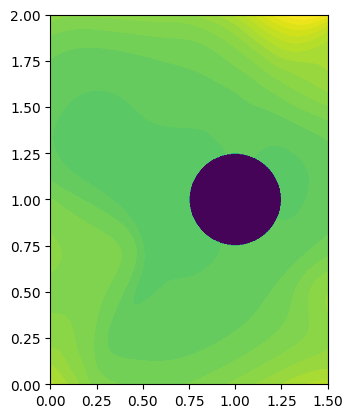

In [11]:
plt.figure()
plt.contourf(x_grid[:,0,:],y_grid[:,0,:],ue,60)
ax = plt.gca()
ax.set_aspect(1)
plt.show()
plt.savefig("Riemann2.pdf", dpi=150)
